**Imports and library downloads**

In [1]:
# https://hackernoon.com/how-to-use-google-trends-api-with-python
!pip install pytrends
!pip install python-dotenv
!pip install newsapi-python
!pip install GoogleNews
!pip install newspaper3k

In [2]:
import pandas as pd
import requests
import json 
import pandas as pd
import datetime as dt
from dotenv import load_dotenv
import nltk as nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from dotenv import load_dotenv
from newsapi import NewsApiClient
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()
from GoogleNews import GoogleNews
from newspaper import Article
import pandas as pd
import matplotlib.pyplot as plt        
from pytrends.request import TrendReq
import time
pytrend = TrendReq(hl='en-US', tz=360) 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Tony\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Gathering data for analysis
In this section, we use binance api to gather daily candlestick data for bitcoin from 2017 onwards

Reference :https://quantnomad.com/2020/11/19/
running-a-massive-backtest-on-1m-bars-in-python-with-backtrader/

In [3]:
# This function uses binance api and gathers 1000 days of data and returns as dataframe.

def get_binance_bars(symbol, interval, startTime, endTime):
 
    url = "https://api.binance.com/api/v3/klines"
 
    startTime = str(int(startTime.timestamp() * 1000))
    endTime = str(int(endTime.timestamp() * 1000))
    limit = '1000'
 
    req_params = {"symbol" : symbol, 'interval' : interval, 'startTime' : startTime, 'endTime' : endTime, 'limit' : limit}
 
    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text))
 
    if (len(df.index) == 0):
        return None
     
    df = df.iloc[:, 0:6]
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
 
    df.open      = df.open.astype("float")
    df.high      = df.high.astype("float")
    df.low       = df.low.astype("float")
    df.close     = df.close.astype("float")
    df.volume    = df.volume.astype("float")
    
    df.index = [dt.datetime.fromtimestamp(x / 1000.0) for x in df.datetime]
    df.datetime = df.datetime/1000
    return df

In [5]:
# Using this function, it calls the get_binance_bars and concatenates them into a single data frame from 2017 onwards. The latest data available from the binacne api is 2017-08-18

def get_ohlcv_dataframe(symbol):
    df_list = []
    last_datetime = dt.datetime(2017, 1, 1)
    while True:
        new_df = get_binance_bars(symbol, '1d', last_datetime, dt.datetime.now())
        if new_df is None:
            break
        df_list.append(new_df)
        last_datetime = max(new_df.index) + dt.timedelta(0, 1)

    df = pd.concat(df_list)
    return df

In [6]:
# Store the candlestick data into a dataframe and calculate the daily percent change

bitcoin_df = get_ohlcv_dataframe('BTCUSDT')
bitcoin_df['returns'] = bitcoin_df['close'].pct_change()
bitcoin_df.dropna(inplace=True)
bitcoin_df.head()

,datetime,open,high,low,close,volume,returns
2017-08-18 10:00:00,1.503014e+09,4285.08,4371.52,3938.77,4108.37,1199.888264,-0.041238
2017-08-19 10:00:00,1.503101e+09,4108.37,4184.69,3850.00,4139.98,381.309763,0.007694
2017-08-20 10:00:00,1.503187e+09,4120.98,4211.08,4032.62,4086.29,467.083022,-0.012969
2017-08-21 10:00:00,1.503274e+09,4069.13,4119.62,3911.79,4016.00,691.743060,-0.017201
2017-08-22 10:00:00,1.503360e+09,4016.00,4104.82,3400.00,4040.00,966.684858,0.005976


In [7]:
# Create a class series, which will be used as target for the machine learning models, we define daily price movement over 10% as 1, under 10% as -1 else 0

bitcoin_df['class'] = 0
bitcoin_df.loc[bitcoin_df['returns']>=0.1, 'class'] = 1
bitcoin_df.loc[bitcoin_df['returns']<=-0.1, 'class'] = -1
bitcoin_df.head()

,datetime,open,high,low,close,volume,returns,class
2017-08-18 10:00:00,1.503014e+09,4285.08,4371.52,3938.77,4108.37,1199.888264,-0.041238,0
2017-08-19 10:00:00,1.503101e+09,4108.37,4184.69,3850.00,4139.98,381.309763,0.007694,0
2017-08-20 10:00:00,1.503187e+09,4120.98,4211.08,4032.62,4086.29,467.083022,-0.012969,0
2017-08-21 10:00:00,1.503274e+09,4069.13,4119.62,3911.79,4016.00,691.743060,-0.017201,0
2017-08-22 10:00:00,1.503360e+09,4016.00,4104.82,3400.00,4040.00,966.684858,0.005976,0


<AxesSubplot:>

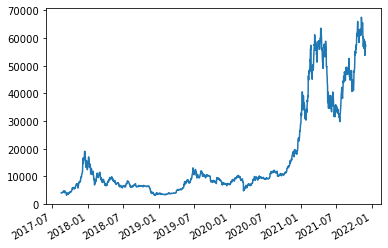

In [8]:
# Visualise the closing prices
bitcoin_df['close'].plot()

<AxesSubplot:>

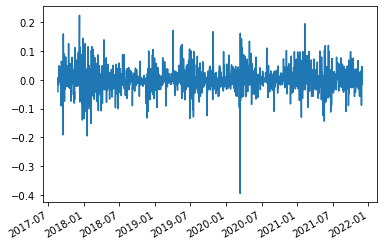

In [9]:
# Visualiose the daily returns
bitcoin_df['returns'].plot()

In [10]:
# Save the dataframe into a csv file
bitcoin_df.to_csv('bitcoin_df.csv')

## Getting Daily Sentiment Using Google API

In this section, we scrape the news from google news api on bitcoin and concatenate the news for each day in the bitcoin dataframe. We had some difficulties getting all the data at once because the api only gave 90 queries at a time, so we had to gather 16 smaller chunks of data and concatenate them for analysis.


In [12]:
# This section of code was to test if the api was returning data. 
# It searches 'Bitcoin' on a certain day and concatenates all the results into a string to be stored in a dataframe

googlenews=GoogleNews(start='01/01/2021',end='01/01/2021')
googlenews.set_lang('en')
googlenews.search('Bitcoin')
result=googlenews.result()
temp = []
for i in range(len(result)):
    temp.append(result[i]['desc'])
temp2 = ' '.join(temp)
temp2

C:\Users\Tony\anaconda3\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


"The S&P 500 just closed out a year for the ages. Here's what also soared—and fell. These off the mark 2020 Bitcoin price predictions prove that forecasting BTC's value is as futile as picking lottery numbers. For many years, the business tycoon Warren Buffet has condemned bitcoin as an investment telling people that the crypto asset is nothing but gambling. Grayscale brings its total assets under management above $20 billion in time for the start of 2021 as Bitcoin demand intensifies. The Bitcoin market is still crazy, but a lot of people can't even find their Bitcoins. We go looking for lost billions. | Subscribe to our weekly newsletter... The Bitcoin market is still crazy, but a lot of people can't even find their Bitcoins. We go looking for lost billions. | Subscribe to our weekly newsletter... 2020 was unforgettable, especially for Bitcoin. To help memorialize this year for our readers, we asked our network of contributors to reflect on Bitcoin's... Bitcoin vaulted above $29,000 

In [13]:
# This section of code loops the bitcoin dataframe and gets news for each date in that dataframe.
# It applies sentiment analysis on the news for that day and gives a compound, positive, negative, neutral sentiment score.

google_sentiment = []
date_list = bitcoin_df.index.to_list()
for date in date_list[360:450]:
# for date in date_list:
    try:
        googlenews=GoogleNews(start = date.strftime('%m/%d/%Y'), end = date.strftime('%m/%d/%Y'))
        googlenews.set_lang('en')
        googlenews.search('Bitcoin')
        result=googlenews.result()
#         time.sleep(1)
        temp = []
        for i in range(len(result)):
            temp.append(result[i]['desc'])
        text = ' '.join(temp)
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]

        google_sentiment.append({
            "text": text,
            "date": date,
            "Google compound": compound,
            "Google positive": pos,
            "Google negative": neg,
            "Google neutral": neu

        })

    except AttributeError:
        pass
# google_sentiment

C:\Users\Tony\anaconda3\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [14]:
# Store the results into a dataframe
google_sentiment_df = pd.DataFrame(google_sentiment)

# Reorder DataFrame columns
cols = ["date", "text", "Google compound", "Google positive", "Google negative", "Google neutral"]
google_sentiment_df = google_sentiment_df[cols]

google_sentiment_df

,date,text,Google compound,Google positive,Google negative,Google neutral
0,2018-08-13 10:00:00,While Bitcoin has fallen more than the lira in...,0.4767,0.070,0.045,0.885
1,2018-08-14 10:00:00,A 32-year-old has revealed his eye-watering $3...,0.9531,0.095,0.026,0.879
2,2018-08-15 10:00:00,"Bitcoin has taken over all forms of media, fro...",0.8451,0.082,0.030,0.888
3,2018-08-16 10:00:00,Cryptocurrency markets are tentatively posting...,0.9167,0.108,0.055,0.838
4,2018-08-17 10:00:00,The largest US-based cryptocurrency exchange h...,0.9074,0.078,0.014,0.908
...,...,...,...,...,...,...
85,2018-11-06 11:00:00,FOMO Moments More midweek momentum pushes mark...,-0.5624,0.083,0.101,0.816
86,2018-11-07 11:00:00,New Zealand will get its crypto-based dollars ...,-0.3182,0.034,0.043,0.922
87,2018-11-08 11:00:00,A main rule of crypto ought to be 'don't tell ...,-0.8219,0.049,0.079,0.871
88,2018-11-09 11:00:00,Jackson Palmer recently discussed what he call...,-0.9089,0.032,0.072,0.895


In [15]:
# Save the dataframe into a csv file

google_sentiment_df.to_csv('google_sentiment_df_360_450.csv')
# google_sentiment_df[:91].to_csv('google_sentiment_df_0_90.csv')
# reddit_sentiments_df.to_csv('reddit_sentiments_df.csv')

## Getting Daily Sentiment Using Reddit API
Using the pushshift api, we can scrape the comments from reddit to gather sentiment around bitcoin, the arguements it intakes include datatype, query, date, number of comments, etc.

Reference : https://www.jcchouinard.com/how-to-use-reddit-api-with-python/

In [14]:
def get_pushshift_data(data_type, **kwargs):
    """
    Gets data from the pushshift api.
 
    data_type can be 'comment' or 'submission'
    The rest of the args are interpreted as payload.
 
    Read more: https://github.com/pushshift/api
    """
 
    base_url = f"https://api.pushshift.io/reddit/search/{data_type}/"
    payload = kwargs
    request = requests.get(base_url, params=payload)
    return request.json()

In [24]:
# This section of code loops the bitcoin dataframe and gets news for each date in that dataframe.
# It applies sentiment analysis on the news for that day and gives a compound, positive, negative, neutral sentiment score.
# The api uses epoch time where 86400 is 24 hours

reddit_sentiments = []
date_list1 = bitcoin_df.datetime.to_list()
for date in date_list1:
    try:
        try:
            data = get_pushshift_data(data_type="comment",
                                      q="bitcoin",
                                      after=int(date) - 86400,
                                      before=int(date),
                                      size=500,
                                      sort_type="score",
                                      sort="desc").get("data")
        except:
            pass
        temp = []
        for i in range(len(data)):
            temp.append(data[i]['body'])
        text = ' '.join(temp)
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]

        reddit_sentiments.append({
            "text": text,
            "date": date,
            "Reddit compound": compound,
            "Reddit positive": pos,
            "Reddit negative": neg,
            "Reddit neutral": neu

        })
    except AttributeError:
        pass


In [25]:
# Store the results into a dataframe
reddit_sentiments_df = pd.DataFrame(reddit_sentiments)

# Reorder DataFrame columns
cols = ["date", "text", "Reddit compound", "Reddit positive", "Reddit negative", "Reddit neutral"]
reddit_sentiments_df = reddit_sentiments_df[cols]
reddit_sentiments_df.rename(columns = {'date':'datetime'}, inplace = True)

reddit_sentiments_df

,datetime,text,Reddit compound,Reddit positive,Reddit negative,Reddit neutral
0,1.503014e+09,it´s an old bitcoin breadwallet! This is good ...,0.9999,0.132,0.082,0.786
1,1.503101e+09,My favourite part is when he calls r/btc more ...,0.9998,0.122,0.090,0.788
2,1.503187e+09,That feeling when your friends talked you out ...,0.9998,0.128,0.109,0.763
3,1.503274e+09,if you had any doubt: this is how you fight bi...,0.9998,0.129,0.104,0.767
4,1.503360e+09,&gt; At the end she broke down crying saying ...,0.9998,0.131,0.108,0.761
...,...,...,...,...,...,...
1556,1.637453e+09,I have a memory of sitting at work and my idio...,0.9992,0.124,0.097,0.779
1557,1.637539e+09,Not buying Bitcoin the first time I read about...,0.9999,0.114,0.073,0.813
1558,1.637626e+09,Why bonds anyway? Why not go DAO? Imagine Bitc...,0.9998,0.114,0.073,0.813
1559,1.637712e+09,Why bonds anyway? Why not go DAO? Imagine Bitc...,0.9998,0.114,0.073,0.813


In [26]:
# Save the dataframe into a csv
reddit_sentiments_df.to_csv('reddit_sentiments_df.csv')